<a id = "top"></a>

# Recommender systems
# Final project
# Hybrid-based Filtering

<img src="https://weadapt.org/wp-content/uploads/2023/05/mcgill-university-logo.jpg" width="100" >

### Instructor: Etienne Tajeuna - etienne.tajeuna@mcgill.ca
### Teaching assistant Dima Al Saleh - dima.alsaleh@mcgill.ca


<img src="https://upload.wikimedia.org/wikipedia/commons/8/86/Logo_emlyon_2021.png" width="80" alt="Emlyon Logo">


- Romain THOMAS


**Date:** 2024-06-22

---

---

## Importing the library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
pd.set_option("display.max_rows", None)
# ! pip install --upgrade pandas

In [2]:
from scipy.sparse import csr_matrix
from itertools import combinations


try:
    import igraph as ig
except:
    !pip install igraph
    !pip install python-igraph
    import igraph as ig

from igraph import Graph

from sklearn.decomposition import PCA

from sklearn.model_selection import KFold

from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score



# Page 3/9

### Loading the former datasets and reducing their size

In [3]:
# Rating df

df_rating = pd.read_csv('./ml-25m/ratings.csv')
display(df_rating.head(3))
df_rating.info()

userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [4]:
# Previous user_profiles
# user_profiles.csv

user_profiles_df = pd.read_csv('user_profiles.csv')
user_profiles_df = user_profiles_df.drop(['Unnamed: 0'], axis =1)
user_profiles_df.head()

userId      IMAX     Drama  Documentary    Sci-Fi  Animation   Mystery  \
0     1.0  0.000000  2.928571     0.028571  0.264286   0.114286  0.200000   
1     2.0  0.154891  1.766304     0.000000  0.611413   0.334239  0.160326   
2     3.0  0.463247  1.382083     0.014548  1.256508   0.297856  0.357580   
3     4.0  0.414583  0.764583     0.085417  1.089583   0.427083  0.285417   
4     5.0  0.118812  1.702970     0.000000  0.445545   0.148515  0.326733   

     Action   Musical  Children    Comedy  Thriller  Film-Noir   Western  \
0  0.235714  0.264286  0.164286  1.271429  0.307143   0.050000  0.035714   
1  1.326087  0.195652  0.497283  1.135870  0.625000   0.000000  0.067935   
2  1.857580  0.032925  0.272588  0.931087  1.346861   0.032925  0.045942   
3  1.914583  0.106250  0.375000  1.218750  0.816667   0.000000  0.106250   
4  0.663366  0.257426  0.297030  1.732673  0.950495   0.000000  0.148515   

    Romance     Crime    Horror   Fantasy  Adventure       War  
0  1.071429  0.464286  0.050000  0.257143   0.585714  0.278571  
1  0.584239  0.307065  0.065217  0.627717   1.592391  0.279891  
2  0.324655  0.785605  0.244257  0.446401   1.107198  0.147014  
3  0.143750  0.612500  0.131250  0.460417   1.429167  0.125000  
4  0.702970  0.574257  0.138614  0.277228   0.801980  0.089109

In [5]:
# setting the userId column as a category to use the stratify function of train_test_split to reduce the size of the datasets

df_rating["userId"] = df_rating["userId"].astype("category")


In [6]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype   
---  ------     -----   
 0   userId     category
 1   movieId    int64   
 2   rating     float64 
 3   timestamp  int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 672.8 MB


In [7]:
# checking the lenght

print(len(user_profiles_df))

162541


In [8]:
df_rating_excluded, df_rating_small = train_test_split(df_rating, test_size=0.02, random_state=42, stratify=df_rating["userId"])

In [9]:
print(len(df_rating_small))

500002


#### Reducing even more the df_rating_small to make the draft tries quick

In [10]:
print(df_rating_small["userId"].nunique())
display(df_rating_small["userId"].unique())


143157


[161965, 45041, 120600, 70176, 141915, ..., 27914, 15389, 91999, 55722, 80288]
Length: 143157
Categories (162541, int64): [1, 2, 3, 4, ..., 162538, 162539, 162540, 162541]

In [11]:
# List of user IDs to filter
user_ids_to_keep = df_rating_small["userId"].unique()[:500] # to update to increase or decrease the size for drafting

# Filter df_rating_small based on user IDs
df_rating_small = df_rating_small[df_rating_small["userId"].isin(user_ids_to_keep)]

display(df_rating_small.head())


userId  movieId  rating   timestamp
24906767  161965     2160     3.0   945223708
6943152    45041     2010     5.0  1162414476
18610081  120600     4446     4.0  1206652566
10814434   70176     1200     4.0  1529953706
21829294  141915     1515     3.0   864913704

In [12]:
print(df_rating_small["userId"].nunique())
display(df_rating_small["userId"].unique())

500


[161965, 45041, 120600, 70176, 141915, ..., 75455, 158686, 23968, 104518, 9703]
Length: 500
Categories (162541, int64): [1, 2, 3, 4, ..., 162538, 162539, 162540, 162541]

In [13]:
print(len(df_rating_small))

6048


In [14]:
# adjusting the user_profiles_df to match the df_rating_small's users

user_profiles_df_small = user_profiles_df[user_profiles_df["userId"].isin(user_ids_to_keep)]
user_profiles_df_small.head()

userId      IMAX     Drama  Documentary    Sci-Fi  Animation   Mystery  \
434    435.0  0.072314  1.760331     0.000000  0.328512   0.398760  0.353306   
901    902.0  0.062500  2.575368     0.029412  0.251838   0.119485  0.360294   
1470  1471.0  0.211207  1.741379     0.000000  0.456897   0.237069  0.228448   
1651  1652.0  0.178689  1.890164     0.032787  0.483607   0.320765  0.413661   
1954  1955.0  0.344037  1.621560     0.112385  0.511468   0.403670  0.355505   

        Action   Musical  Children    Comedy  Thriller  Film-Noir   Western  \
434   0.871901  0.353306  0.671488  1.561983  0.834711   0.000000  0.078512   
901   0.551471  0.108456  0.165441  0.858456  0.830882   0.011029  0.047794   
1470  0.375000  0.081897  0.495690  1.306034  0.745690   0.000000  0.030172   
1651  1.024044  0.063388  0.309563  1.324317  1.337158   0.068579  0.040164   
1954  0.841743  0.011468  0.369266  1.009174  0.798165   0.000000  0.036697   

       Romance     Crime    Horror   Fantasy  Adventure       War  
434   0.977273  0.543388  0.070248  0.342975   0.851240  0.123967  
901   1.073529  0.575368  0.277574  0.375000   0.737132  0.318015  
1470  1.232759  0.241379  0.142241  0.396552   0.715517  0.000000  
1651  0.626776  0.848634  0.324317  0.327596   0.665301  0.136339  
1954  0.559633  0.722477  0.087156  0.396789   0.823394  0.126147

### Graph construction: Name of the document to return graph representation.csv

In [15]:
"""
you are asked to create the graph of user preferences.
For this, you have to create the dataframe given as this dataframe:
from to weight
x     x   x


where the columns “from” and “to” will have user ids 
whereas column “weight” will have the number of items two users well rated (that is rating> 2) together.

 For instance in the file “ratings.csv”, the userId 1 and 2 both
well rated 212 movies. In this case, the dataframe will have the row with
values: (1, 2, 4).

In this file, two users should be recorded if and only if they both well rated at least 2.
The dataframe should be returned into a csv file called “graph representation”.
"""

'\nyou are asked to create the graph of user preferences.\nFor this, you have to create the dataframe given as this dataframe:\nfrom to weight\nx     x   x\n\n\nwhere the columns “from” and “to” will have user ids \nwhereas column “weight” will have the number of items two users well rated (that is rating> 2) together.\n\n For instance in the file “ratings.csv”, the userId 1 and 2 both\nwell rated 212 movies. In this case, the dataframe will have the row with\nvalues: (1, 2, 4).\n\nIn this file, two users should be recorded if and only if they both well rated at least 2.\nThe dataframe should be returned into a csv file called “graph representation”.\n'

In [16]:
df_rating_small.head(3)

userId  movieId  rating   timestamp
24906767  161965     2160     3.0   945223708
6943152    45041     2010     5.0  1162414476
18610081  120600     4446     4.0  1206652566

In [17]:
# Create a matrix where rows represent users, columns represent movies, and values represent ratings.

from scipy.sparse import csr_matrix

# Convert train_df to a sparse matrix
rows = df_rating_small['userId'].values.as_ordered()
cols = df_rating_small['movieId'].values
data = df_rating_small['rating'].values

# Create a sparse matrix
rating_matrix_sparse = csr_matrix((data, (rows, cols)))

print(rating_matrix_sparse)

  (435, 153)	3.0
  (435, 434)	2.5
  (435, 2571)	4.0
  (435, 3448)	4.0
  (435, 4011)	4.0
  (902, 3083)	4.0
  (902, 3969)	4.0
  (902, 4361)	3.5
  (902, 5791)	4.0
  (902, 45722)	4.5
  (1471, 1682)	5.0
  (1471, 7293)	4.0
  (1652, 456)	4.5
  (1652, 913)	4.5
  (1652, 924)	3.0
  (1652, 1029)	4.0
  (1652, 1343)	4.5
  (1652, 1544)	4.0
  (1652, 2571)	5.0
  (1652, 3316)	3.0
  (1652, 3556)	3.5
  (1652, 3683)	4.0
  (1652, 3947)	3.5
  (1652, 5147)	4.0
  (1652, 5434)	4.5
  :	:
  (162508, 940)	4.5
  (162508, 1235)	2.0
  (162508, 1994)	5.0
  (162508, 2707)	4.5
  (162508, 2947)	3.5
  (162508, 4334)	0.5
  (162508, 5294)	5.0
  (162508, 5673)	2.5
  (162508, 5812)	2.5
  (162508, 6031)	5.0
  (162508, 6183)	4.5
  (162508, 6232)	4.0
  (162508, 6522)	4.5
  (162508, 6539)	4.5
  (162508, 6611)	1.5
  (162508, 6688)	4.0
  (162508, 7944)	1.0
  (162508, 26034)	3.5
  (162508, 26318)	1.0
  (162508, 27857)	3.5
  (162508, 33316)	1.5
  (162508, 39307)	4.0
  (162508, 49961)	2.0
  (162508, 71438)	1.5
  (162508, 91537)	3.5


In [18]:
from itertools import combinations

# Extract user IDs and movie IDs from rating_matrix_sparse
users, movies = rating_matrix_sparse.nonzero()

# Create a DataFrame from the sparse matrix
df_rating_sparse = pd.DataFrame({'userId': users, 'movieId': movies, 'rating': rating_matrix_sparse.data})

# Initialize an empty list to store rows
rows = []

# Iterate over pairs of users to calculate the number of common movies rated
for user1, user2 in combinations(df_rating_sparse['userId'].unique(), 2):
    # Filter movies rated by user1 and user2 with ratings > 2
    movies_user1 = set(df_rating_sparse[(df_rating_sparse['userId'] == user1) & (df_rating_sparse['rating'] > 2)]['movieId'])
    movies_user2 = set(df_rating_sparse[(df_rating_sparse['userId'] == user2) & (df_rating_sparse['rating'] > 2)]['movieId'])
    
    # Calculate the number of common movies rated
    count = len(movies_user1.intersection(movies_user2))
    
    if count > 0:
        rows.append({'from': user1, 'to': user2, 'weight': count})

# Create the result DataFrame
result_df = pd.DataFrame(rows)

display(result_df.head())

from     to  weight
0   435   1652       1
1   435   8402       1
2   435   9276       1
3   435  30879       1
4   435  50138       1

In [19]:

# saving the detail dataset into a csv

from datetime import datetime

# datetime object containing current date and time
now = datetime.now()

print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y-%m-%d_%Hh%M")
print("date and time =", dt_string)


result_df.to_csv("graph_representation.csv")


now = 2024-06-24 20:45:18.430788
date and time = 2024-06-24_20h45


In [20]:
graph_representation = result_df

# Page 4/9

In [21]:
"""
Based on files user_profiles.csv and graph_representation.csv we want to learn
novel user representation for recommendation purpose.

Using igraph, build the graph of users G. Each node of the graph should be
the userId found in user_profiles.csv.
"""

'\nBased on files user_profiles.csv and graph_representation.csv we want to learn\nnovel user representation for recommendation purpose.\n\nUsing igraph, build the graph of users G. Each node of the graph should be\nthe userId found in user_profiles.csv.\n'

In [22]:
graph_representation.head(3)

from    to  weight
0   435  1652       1
1   435  8402       1
2   435  9276       1

In [23]:
graph_representation["weight"].unique()

array([1, 2, 3, 4], dtype=int64)

IGRAPH U-W- 500 3696 -- 
+ attr: weight (e)


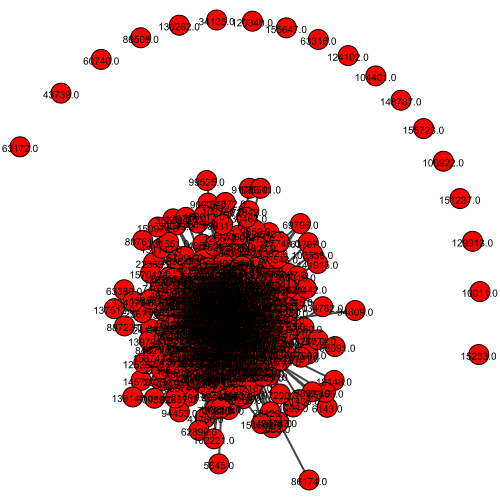

In [24]:
try:
    import igraph as ig
except:
    !pip install igraph
    !pip install python-igraph
    import igraph as ig

# Initialize an empty graph
G = ig.Graph()

# Extract unique userIds from user_profiles
user_ids = user_profiles_df[user_profiles_df["userId"].isin(user_ids_to_keep)]["userId"].unique()

# Create a mapping from userId to vertex index in the graph
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}

# Add vertices (nodes) to the graph
G.add_vertices(len(user_ids))

# Add edges and edge attributes from dataframe
for _, row in graph_representation.iterrows():
    from_node = row['from']
    to_node = row['to']
    weight = row['weight']
    
    # Check if both from_node and to_node are in user_id_to_index
    if from_node in user_id_to_index and to_node in user_id_to_index:
        from_idx = user_id_to_index[from_node]
        to_idx = user_id_to_index[to_node]
        
        # Add edge between from_idx and to_idx with weight attribute
        G.add_edge(from_idx, to_idx, weight=weight)
    else:
        print(f"Skipping edge ({from_node}, {to_node}) as one or both nodes are not in user_ids.")

# Print basic information about the graph
print(G.summary())

# Optionally, visualize the graph
layout = G.layout_fruchterman_reingold()
visual_style = {
    "vertex_size": 20,
    "vertex_label_size": 10,
    "edge_width": [1 + weight for weight in G.es["weight"]],  # Adjust the multiplier as needed
    "layout": layout,
    "bbox": (500, 500),
    "margin": 20
}

G.vs['label'] = [str(user_id) for user_id in user_ids]  # Set labels as user IDs
G.vs['size'] = 10  # Set node size

# Plot the graph
ig.plot(G, **visual_style)


In [25]:
import igraph as ig
import pandas as pd


# Print basic information about the graph
print("Graph summary:")
print(G.summary())

# Print edges and their attributes
print("\nEdges:")
for edge in G.es:
    source_label = G.vs[edge.source]['label']
    target_label = G.vs[edge.target]['label']
    print(f"Edge {edge.index}: Source={edge.source}, Label={source_label}, Target={edge.target}, Label={target_label}, Attributes={edge.attributes()}")

# Example: Store edges and their attributes in a list of dictionaries
edges_info = []
for edge in G.es:
    source_label = G.vs[edge.source]['label']
    target_label = G.vs[edge.target]['label']
    edge_info = {
        'from': edge.source,
        'from_label': source_label,
        'to': edge.target,
        'to_label': target_label,
        'weight': edge['weight']  # Example: Accessing edge attribute 'weight'
    }
    edges_info.append(edge_info)

# Display edge information
print("\nEdges Information:")
for edge_info in edges_info:
    print(edge_info)


Graph summary:
IGRAPH U-W- 500 3696 -- 
+ attr: label (v), size (v), weight (e)

Edges:
Edge 0: Source=0, Label=435.0, Target=3, Label=1652.0, Attributes={'weight': 1}
Edge 1: Source=0, Label=435.0, Target=20, Label=8402.0, Attributes={'weight': 1}
Edge 2: Source=0, Label=435.0, Target=23, Label=9276.0, Attributes={'weight': 1}
Edge 3: Source=0, Label=435.0, Target=98, Label=30879.0, Attributes={'weight': 1}
Edge 4: Source=0, Label=435.0, Target=152, Label=50138.0, Attributes={'weight': 1}
Edge 5: Source=0, Label=435.0, Target=252, Label=82960.0, Attributes={'weight': 1}
Edge 6: Source=0, Label=435.0, Target=308, Label=99779.0, Attributes={'weight': 1}
Edge 7: Source=0, Label=435.0, Target=313, Label=100445.0, Attributes={'weight': 1}
Edge 8: Source=0, Label=435.0, Target=331, Label=104518.0, Attributes={'weight': 1}
Edge 9: Source=0, Label=435.0, Target=340, Label=109480.0, Attributes={'weight': 1}
Edge 10: Source=0, Label=435.0, Target=416, Label=139114.0, Attributes={'weight': 1}
Ed

In [26]:
"""
We call adjacency matrix, the matrix A = (ai,j ), where ai,j = 0 if there is no
edge between userId “i” and “j”. In case there is an edge ai,j should be the
weight of the graph, that is the number of movies they well rated together
(this value can be read from the data graph representation ).

Determine the adjacency matrix A of the graph.


We call degree matrix, the matrix D = (di,j ), where di,j = 0 if i ̸= j. In case
i = j di,j should be the degree of the node i.

Determine the degree matrix D of the graph.


Based on the adjacency matrix and the degree matrix,
calculate the Laplacian matrix L = D − A

"""

'\nWe call adjacency matrix, the matrix A = (ai,j ), where ai,j = 0 if there is no\nedge between userId “i” and “j”. In case there is an edge ai,j should be the\nweight of the graph, that is the number of movies they well rated together\n(this value can be read from the data graph representation ).\n\nDetermine the adjacency matrix A of the graph.\n\n\nWe call degree matrix, the matrix D = (di,j ), where di,j = 0 if i ̸= j. In case\ni = j di,j should be the degree of the node i.\n\nDetermine the degree matrix D of the graph.\n\n\nBased on the adjacency matrix and the degree matrix,\ncalculate the Laplacian matrix L = D − A\n\n'

In [27]:
import pandas as pd
import numpy as np


# Construct the adjacency matrix A
nodes = sorted(set(graph_representation['from']).union(set(graph_representation['to'])))
num_nodes = len(nodes)
adjacency_matrix = np.zeros((num_nodes, num_nodes))

for idx, row in graph_representation.iterrows():
    from_node = row['from']
    to_node = row['to']
    weight = row['weight']
    
    from_idx = nodes.index(from_node)
    to_idx = nodes.index(to_node)
    
    adjacency_matrix[from_idx][to_idx] = weight
    adjacency_matrix[to_idx][from_idx] = weight  # Assuming undirected graph

# Construct the degree matrix D
degree_matrix = np.zeros((num_nodes, num_nodes))

for i in range(num_nodes):
    degree_matrix[i][i] = np.sum(adjacency_matrix[i])

# Calculate the Laplacian matrix L = D - A
laplacian_matrix = degree_matrix - adjacency_matrix

# Convert matrices to pandas DataFrames for better visualization (optional)
nodes_labels = [str(node) for node in nodes]

adjacency_df = pd.DataFrame(adjacency_matrix, index=nodes_labels, columns=nodes_labels)
degree_df = pd.DataFrame(degree_matrix, index=nodes_labels, columns=nodes_labels)
laplacian_df = pd.DataFrame(laplacian_matrix, index=nodes_labels, columns=nodes_labels)

# Print matrices (optional)
print("Adjacency Matrix A:")
display(adjacency_df)

print("\nDegree Matrix D:")
display(degree_df)

print("\nLaplacian Matrix L:")
display(laplacian_df)


Adjacency Matrix A:


435  902  1471  1652  1955  1998  2177  3396  3445  3503  ...  159964  \
435     0.0  0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
902     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
1471    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
1652    1.0  0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  ...     0.0   
1955    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
1998    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
2177    0.0  0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
3396    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
3445    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
3503    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
4294    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
4540    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
4559    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
4741    0.0  0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...     0.0   
4859    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
5645    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
6025    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
6143    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
6204    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
8069    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
8402    1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
8460    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
9142    0.0  0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
9276    1.0  0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
9652    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
9703    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
10045   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
10736   0.0  1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
11445   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
11491   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
11747   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
12103   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
12835   0.0  0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  ...     0.0   
13063   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
13226   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
14570   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
14806   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
14831   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
14997   0.0  0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0  ...     0.0   
15443   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
15542   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
15670   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...     0.0   
15806   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
15832   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
16627   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
16774   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...     0.0   
16831   0.0  0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
17084   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...     0.0   
18148   0.0  0.0   0.0   0.0   0.0   0.


Degree Matrix D:


435  902  1471  1652  1955  1998  2177  3396  3445  3503  ...  \
435     12.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
902      0.0  6.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1471     0.0  0.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1652     0.0  0.0   0.0  32.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1955     0.0  0.0   0.0   0.0  13.0   0.0   0.0   0.0   0.0   0.0  ...   
1998     0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   
2177     0.0  0.0   0.0   0.0   0.0   0.0  60.0   0.0   0.0   0.0  ...   
3396     0.0  0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0   0.0  ...   
3445     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  23.0   0.0  ...   
3503     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  33.0  ...   
4294     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4540     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4559     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4741     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4859     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5645     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6025     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6143     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6204     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8069     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8402     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8460     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9142     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9276     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9652     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9703     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
10045    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
10736    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
11445    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
11491    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
11747    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
12103    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
12835    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
13063    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
13226    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14570    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14806    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14831    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14997    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15443    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15542    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15670    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15806    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15832    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
16627    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
16774    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
16831    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
17084    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
18148    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
18551    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19090    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19122    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19182    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19247    0.0 


Laplacian Matrix L:


435  902  1471  1652  1955  1998  2177  3396  3445  3503  ...  \
435     12.0  0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
902      0.0  6.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1471     0.0  0.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1652    -1.0  0.0   0.0  32.0   0.0   0.0  -1.0   0.0   0.0   0.0  ...   
1955     0.0  0.0   0.0   0.0  13.0   0.0   0.0   0.0   0.0   0.0  ...   
1998     0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   
2177     0.0  0.0   0.0  -1.0   0.0   0.0  60.0   0.0   0.0   0.0  ...   
3396     0.0  0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0   0.0  ...   
3445     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  23.0   0.0  ...   
3503     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  33.0  ...   
4294     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4540     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4559     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4741     0.0  0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0   0.0  ...   
4859     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5645     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6025     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6143     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6204     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8069     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8402    -1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8460     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9142     0.0  0.0   0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0  ...   
9276    -1.0  0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9652     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9703     0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
10045    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
10736    0.0 -1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
11445    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
11491    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
11747    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
12103    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
12835    0.0  0.0   0.0   0.0   0.0   0.0  -1.0   0.0   0.0   0.0  ...   
13063    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
13226    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14570    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14806    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14831    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
14997    0.0  0.0   0.0  -1.0   0.0   0.0  -1.0   0.0   0.0   0.0  ...   
15443    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15542    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15670    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0  ...   
15806    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
15832    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
16627    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
16774    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0  ...   
16831    0.0  0.0   0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0  ...   
17084    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
18148    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
18551    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19090    0.0  0.0   0.0   0.0   0.0   0.0  -1.0   0.0   0.0   0.0  ...   
19122    0.0  0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19182    0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19247    0.0 

In [28]:
A = adjacency_matrix

D = degree_matrix

L = laplacian_matrix

A_df = adjacency_df

D_df = degree_df

L_df = laplacian_df

In [29]:
"""
Calculate the matrix M = L · X, where X should be the matrix of user
profile.

"""

'\nCalculate the matrix M = L · X, where X should be the matrix of user\nprofile.\n\n'

In [30]:
# we need to adapt the user_profiles_df_small to match the L matrix
# in term of number and which users are taken into account
# and in term of order of "userId" rows and columns

# Convert L_df.columns to float
L_df_columns = [float(col) for col in L_df.columns]

# Filter user_profiles_df_small based on user IDs present in L_df.columns
filtered_user_profiles = user_profiles_df_small[user_profiles_df_small['userId'].isin(L_df_columns)]

# Print the filtered DataFrame
filtered_user_profiles = filtered_user_profiles.sort_values("userId")
filtered_user_profiles.head(3)


userId      IMAX     Drama  Documentary    Sci-Fi  Animation   Mystery  \
434    435.0  0.072314  1.760331     0.000000  0.328512   0.398760  0.353306   
901    902.0  0.062500  2.575368     0.029412  0.251838   0.119485  0.360294   
1470  1471.0  0.211207  1.741379     0.000000  0.456897   0.237069  0.228448   

        Action   Musical  Children    Comedy  Thriller  Film-Noir   Western  \
434   0.871901  0.353306  0.671488  1.561983  0.834711   0.000000  0.078512   
901   0.551471  0.108456  0.165441  0.858456  0.830882   0.011029  0.047794   
1470  0.375000  0.081897  0.495690  1.306034  0.745690   0.000000  0.030172   

       Romance     Crime    Horror   Fantasy  Adventure       War  
434   0.977273  0.543388  0.070248  0.342975   0.851240  0.123967  
901   1.073529  0.575368  0.277574  0.375000   0.737132  0.318015  
1470  1.232759  0.241379  0.142241  0.396552   0.715517  0.000000

In [31]:
# creating the corresponding X matrix of user profile

X_df = filtered_user_profiles.copy()
X_df = X_df.set_index('userId', drop=True)
X_df.head(3)

IMAX     Drama  Documentary    Sci-Fi  Animation   Mystery  \
userId                                                                   
435.0   0.072314  1.760331     0.000000  0.328512   0.398760  0.353306   
902.0   0.062500  2.575368     0.029412  0.251838   0.119485  0.360294   
1471.0  0.211207  1.741379     0.000000  0.456897   0.237069  0.228448   

          Action   Musical  Children    Comedy  Thriller  Film-Noir   Western  \
userId                                                                          
435.0   0.871901  0.353306  0.671488  1.561983  0.834711   0.000000  0.078512   
902.0   0.551471  0.108456  0.165441  0.858456  0.830882   0.011029  0.047794   
1471.0  0.375000  0.081897  0.495690  1.306034  0.745690   0.000000  0.030172   

         Romance     Crime    Horror   Fantasy  Adventure       War  
userId                                                               
435.0   0.977273  0.543388  0.070248  0.342975   0.851240  0.123967  
902.0   1.073529  0.575368  0.277574  0.375000   0.737132  0.318015  
1471.0  1.232759  0.241379  0.142241  0.396552   0.715517  0.000000

In [32]:
print(A_df.shape)

print(D_df.shape)

print(L_df.shape)

print(X_df.shape)

(482, 482)
(482, 482)
(482, 482)
(482, 19)


In [33]:
# Calculate M = L · X
M = np.dot(L, X_df)

# Convert M to a pandas DataFrame
# Assuming user_ids and feature_labels are defined appropriately
user_ids = L_df.columns  # Replace with actual user labels or ids
feature_labels = X_df.columns  # Replace with actual feature labels

M_df = pd.DataFrame(M, index=user_ids, columns=feature_labels)

# Print the resulting DataFrame M
print("DataFrame M = L * X:")
display(M_df)

DataFrame M = L * X:


IMAX      Drama  Documentary     Sci-Fi  Animation    Mystery  \
435     -0.790243   0.821353    -0.503918  -1.420510   1.964104   0.410269   
902     -0.723752   5.004309    -0.042969  -2.277858   0.064327   0.241241   
1471     0.112571   2.248955    -0.130387  -0.166574  -0.439474   0.056579   
1652     2.055015   7.731950    -0.765755  -0.771054   3.439419   3.755103   
1955     0.034491  -0.174352     0.672453  -5.782030   1.173835  -0.063824   
1998    -0.065972   0.548973     0.002508  -0.134559  -0.053552   0.146815   
2177    -5.039103  14.395391    -2.051203 -13.894147  -5.811116  -3.073602   
3396    -0.278115  -0.623880    -0.037097  -0.663867   0.240633  -0.499160   
3445    -1.193844   5.311812    -0.063950   0.081664  -0.516133   0.419702   
3503    -3.303183  -0.137652     7.971199 -10.718863  -2.940976  -1.059354   
4294    -0.381308  -5.742253    -0.788069  -1.545148   0.782847  -1.304107   
4540     0.052925  -0.738432    -0.116249  -0.844361   0.811941  -0.551595   
4559    -5.872144  10.844994    -1.262043 -15.387260  -6.176198   0.627691   
4741    -1.835361  21.019701     0.521642  -5.724615  -0.992449   0.666010   
4859    -0.093272   1.868919    -0.330589   0.074747  -0.641054  -0.205213   
5645     0.742084   0.245654     0.000000   0.951304  -0.415140  -0.177014   
6025    -0.915583  -8.645416    -0.792324  -3.360328  -2.131452  -0.953066   
6143    -0.057915  -0.771393    -0.038610  -0.500763  -0.324324   0.171141   
6204     0.197356  -0.002217    -0.209258   1.423484   0.319019  -0.008395   
8069    -1.258157   2.264175     0.620323  -3.663167  -1.575099  -0.694048   
8402     0.972666   1.196432    -0.121078  -1.156760   0.161706   0.163597   
8460    -1.149628  -7.589105     0.240474  -1.798229  -0.543347  -1.547057   
9142     1.440445   5.475368     0.348678  -1.446340  -0.451841   1.821032   
9276    -1.009911  18.821353    -0.649716 -11.634355  -1.277052  -1.096773   
9652    -0.366544  -0.620942     0.111365  -0.116656  -0.150319  -0.551334   
9703     3.188230   1.253310    -1.442048   3.101648   3.561525   3.416561   
10045   -2.109471   0.054712     0.525740  -0.853016   6.048877   1.522638   
10736    2.812541   5.178544     0.052001   4.870731  -0.729719   3.359004   
11445    0.634232   0.708692    -0.245746  -1.500626   0.215008  -1.247281   
11491    0.133939   9.764882    -0.697374  -1.741221  -0.341118  -0.163638   
11747   -0.748450 -18.962791    -0.296005  -1.680518  -1.748511  -3.904241   
12103    2.487929 -10.116504    -0.665096   1.274597   8.625296   0.262366   
12835   -4.656284   6.014085     0.726827 -11.023277  -2.295464  -4.021647   
13063    0.117178  -0.844312    -0.125762   0.735056   0.323521  -0.013045   
13226    4.299216 -10.626509    -0.500303   8.166515   3.682728   0.273195   
14570    0.134369   0.582766    -0.098837  -0.056524   0.101545   0.287782   
14806    0.934337  -1.371155    -0.043933  -0.875618   0.479831  -0.107878   
14831   -5.564656  23.011971     2.121578 -16.727057  -3.132145  -0.655418   
14997   -1.611577   4.760751     3.373957  -1.805063   0.169198  -0.104029   
15443   -0.168375   1.145891     1.408060   1.407629  -0.695022   0.833234   
15542   -0.669204   8.620473     2.728189   0.154483  -0.239221   1.523012   
15670    1.306694   2.977342    -0.070347  -1.469573   0.128185  -0.918211   
15806   -2.381785  -3.229672    -1.505896   0.479057  -1.374093   1.264287   
15832    2.601329  -1.162443     0.561481   3.965462   0.724226  -0.660566   
16627    3.813366 -13.311352    -0.913607  11.622535   7.299924   0.318323   
16774    1.201930 -23.883881    -0.985134  10.233033   7.196894  -0.985977   
16831    1.802795   7.487768    -0.469182   2.019885   0.874425   0.808453   
17084   -1.139432  18.511400    -0.867239  -5.589667  -1.618208  -0.757767   
18148    0.169604  -0.519541    -0.025896   0.406015   0.009250  -0.048637   
18551    3.191709   0.760869    -0.813508   9.871096   0.459070   1.328904   
19090   -1.011053  -4.524909    -0.

# Page 5/9

In [34]:
"""
Using a PCA, you are asked to reduce the dimensionality of matrix M to 5.
Return the novel user representation into a file called user_profiles2.csv.
"""

'\nUsing a PCA, you are asked to reduce the dimensionality of matrix M to 5.\nReturn the novel user representation into a file called user_profiles2.csv.\n'

In [35]:
from sklearn.decomposition import PCA


# Apply PCA to reduce dimensionality to 5 components
pca = PCA(n_components=5)
M_reduced = pca.fit_transform(M)

# user IDs (replace with actual user IDs or labels)
user_ids = user_ids

# Convert reduced matrix to DataFrame with user IDs as index
M_reduced_df = pd.DataFrame(M_reduced, index=user_ids, columns=[f'PC{i+1}' for i in range(5)])

# Print the reduced DataFrame
print("Reduced User Profile DataFrame:")
display(M_reduced_df.head(3))

# Save to CSV file
output_file = 'user_profiles2.csv'
M_reduced_df.to_csv(output_file)

print(f"\nSaved reduced user profiles to {output_file}.")


Reduced User Profile DataFrame:


PC1       PC2       PC3       PC4       PC5
435  -1.905156 -2.672621  6.258926 -1.530028  0.274493
902  -5.042284  3.430683  0.340005 -1.970683  0.781701
1471 -2.588157  0.835247  2.190465 -0.228704  0.331362


Saved reduced user profiles to user_profiles2.csv.


Top 5 positive loadings for PC1:
Action       0.576204
Adventure    0.377855
Sci-Fi       0.371085
Thriller     0.276228
Fantasy      0.141263
IMAX         0.112370
Animation    0.097138
Horror       0.088687
Name: PC1, dtype: float64

Top 5 positive loadings for PC2:
Drama       0.704851
Thriller    0.389013
Crime       0.287307
Action      0.204459
Mystery     0.154780
Sci-Fi      0.111070
War         0.099439
IMAX        0.049661
Name: PC2, dtype: float64


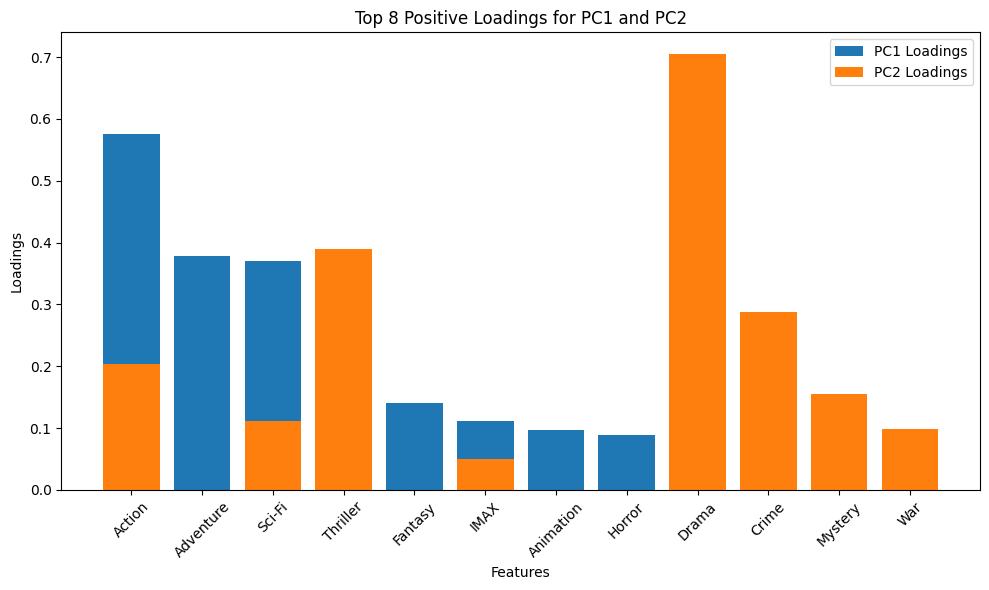

In [36]:
# Tryin to interpret PC1 and PC2

# Extract explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Extract principal components and their loadings
components = pca.components_
loadings = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=M_df.columns)

# Interpret PC1 and PC2
PC1_loadings = loadings['PC1'].sort_values(ascending=False)
PC2_loadings = loadings['PC2'].sort_values(ascending=False)

top = 8

print("Top 5 positive loadings for PC1:")
print(PC1_loadings.head(top))

print("\nTop 5 positive loadings for PC2:")
print(PC2_loadings.head(top))

# Plotting PC1 and PC2 loadings
plt.figure(figsize=(10, 6))
plt.bar(PC1_loadings.index[:top], PC1_loadings[:top], label='PC1 Loadings')
plt.bar(PC2_loadings.index[:top], PC2_loadings[:top], label='PC2 Loadings')
plt.xlabel('Features')
plt.ylabel('Loadings')
plt.title(f'Top {top} Positive Loadings for PC1 and PC2')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


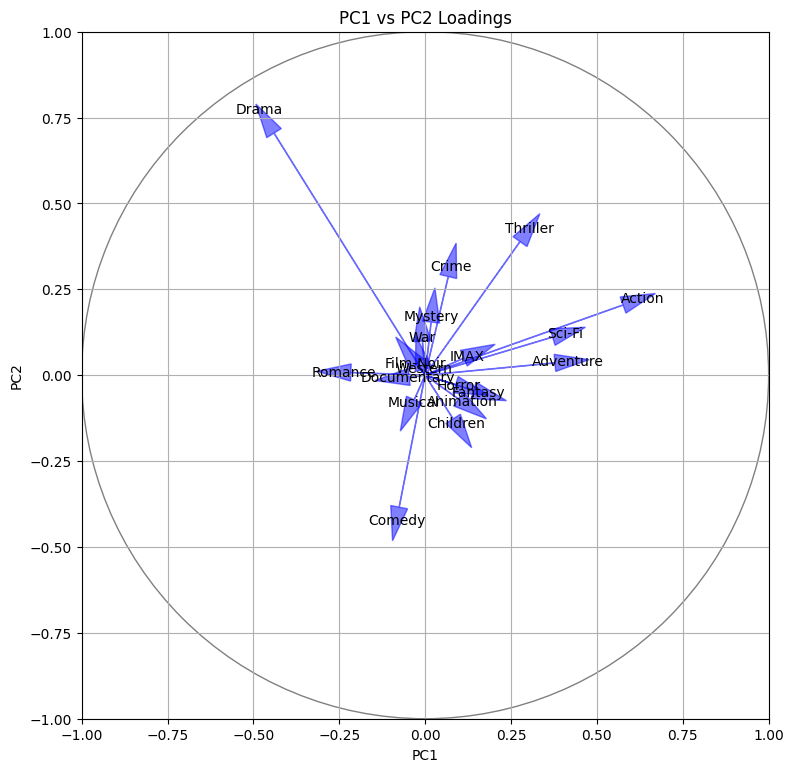

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Example data (assuming M_df is your DataFrame)
# M_df = ... (your data)
# pca = PCA().fit(M_df)

# Extract principal components and their loadings
components = pca.components_
loadings = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=M_df.columns)

# Function to plot PC loadings
def plot_pc_loadings(loadings, pc1, pc2, ax):
    circle = plt.Circle((0, 0), 1, color='gray', fill=False)
    ax.add_artist(circle)
    
    for i in range(loadings.shape[0]):
        ax.arrow(0, 0, loadings.iloc[i, pc1], loadings.iloc[i, pc2],
                 color='blue', alpha=0.5, head_width=0.05, head_length=0.1)
        ax.text(loadings.iloc[i, pc1] * 1.1, loadings.iloc[i, pc2] * 1.1,
                loadings.index[i], color='black', ha='center', va='center')
    
    ax.set_xlabel(f'PC{pc1+1}')
    ax.set_ylabel(f'PC{pc2+1}')
    ax.set_title(f'PC{pc1+1} vs PC{pc2+1} Loadings')
    ax.grid()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_aspect('equal', 'box')

# Plotting PC1 vs PC2 loadings
fig, ax = plt.subplots(figsize=(8, 8))
plot_pc_loadings(loadings, 0, 1, ax)
plt.tight_layout()
plt.show()


In [38]:
"""
Over the obtained representation, perform a K-means with K = 3 to identify
3 clusters of users.
Using the two first component of your PCA, plot your users into a
2-dimensional plan to visualize the users. Each group should be colored
accordingly.
Make an interpratation of your results.

"""

'\nOver the obtained representation, perform a K-means with K = 3 to identify\n3 clusters of users.\nUsing the two first component of your PCA, plot your users into a\n2-dimensional plan to visualize the users. Each group should be colored\naccordingly.\nMake an interpratation of your results.\n\n'


User Profiles with Cluster Labels:


PC1       PC2       PC3       PC4       PC5  cluster
435  -1.905156 -2.672621  6.258926 -1.530028  0.274493        0
902  -5.042284  3.430683  0.340005 -1.970683  0.781701        0
1471 -2.588157  0.835247  2.190465 -0.228704  0.331362        0

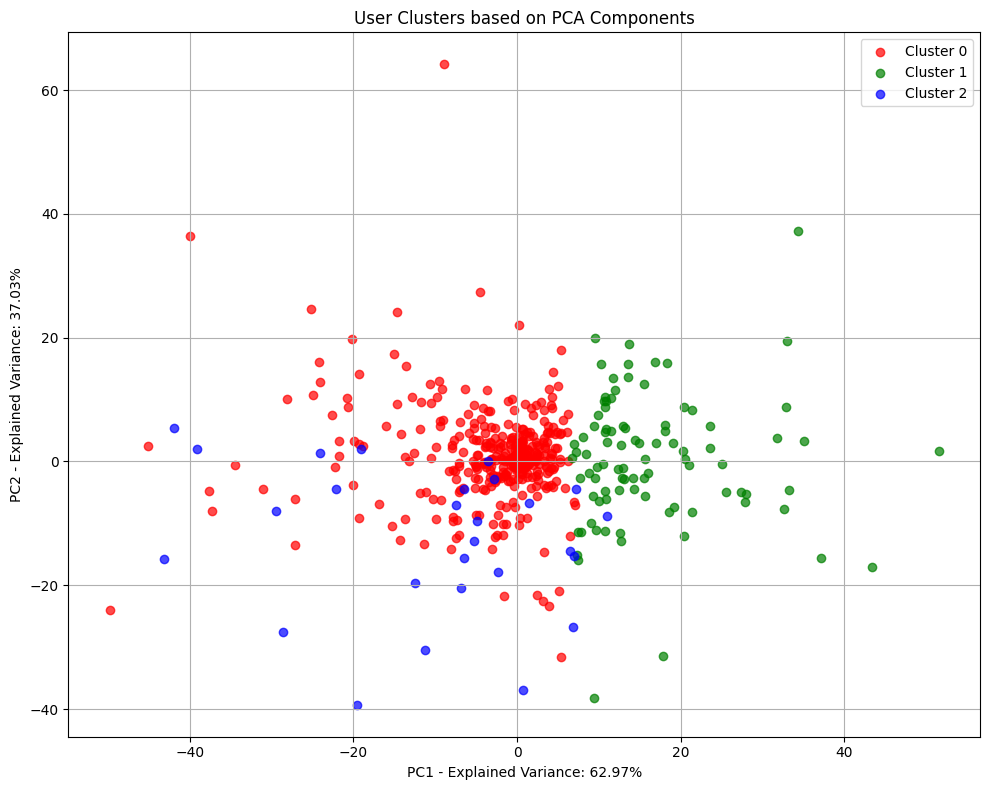

In [39]:
import pandas as pd
from sklearn.cluster import KMeans

# Load the reduced user profiles from the CSV file
# input_file = 'user_profiles2.csv'
# user_profiles_df = pd.read_csv(input_file, index_col=0)

# Display the loaded data
# print("User Profiles:")
# display(user_profiles_df.head(3))

# Perform K-means clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(M_reduced_df)

# Add cluster labels to the DataFrame
M_reduced_df['cluster'] = cluster_labels

# Display the DataFrame with cluster labels
print("\nUser Profiles with Cluster Labels:")
display(M_reduced_df.head(3))

# Extract PCA components
pca_components = M_reduced_df[['PC1', 'PC2']].values

# Extract cluster labels
cluster_labels = M_reduced_df['cluster'].values

# Initialize PCA object to access explained variance ratio
pca = PCA(n_components=2)
pca.fit(pca_components)
explained_var = pca.explained_variance_ratio_

# Plot users in 2D with different colors for each cluster
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.scatter(pca_components[cluster_labels == i, 0], 
                pca_components[cluster_labels == i, 1],
                color=colors[i], alpha=0.7, label=f'Cluster {i}')

plt.title('User Clusters based on PCA Components')
plt.xlabel(f'PC1 - Explained Variance: {explained_var[0]*100:.2f}%')
plt.ylabel(f'PC2 - Explained Variance: {explained_var[1]*100:.2f}%')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


#### Make an interpratation of your results.

In [40]:
"""
Interpretation:
Cluster Separation: Observe how well-separated the clusters are in the 2D plot. Ideally, clusters should appear as distinct groups.
PCA Components: PC1 and PC2 are chosen based on their explained variance. They represent the directions of maximum variance in the data.
Insights: Analyze any patterns or groupings among users within the clusters. Users closer together in the plot may share similar movie preferences or rating behaviors.

WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?
                 WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?
WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?
                 WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?
WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?
                 WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?
WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?
                 WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?
"""

'\nInterpretation:\nCluster Separation: Observe how well-separated the clusters are in the 2D plot. Ideally, clusters should appear as distinct groups.\nPCA Components: PC1 and PC2 are chosen based on their explained variance. They represent the directions of maximum variance in the data.\nInsights: Analyze any patterns or groupings among users within the clusters. Users closer together in the plot may share similar movie preferences or rating behaviors.\n\nWHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?\n                 WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?\nWHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?\n                 WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?\nWHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN WE SAY ABOUT THE REPRESENTATION ?\n                 WHAT CAN WE SAY ABOUT THE REPRESENTATION ? WHAT CAN 

# Page 6/9

In [41]:
"""
We now want to recommend items to users based on their relationships.

For this we will use the logic of link prediction in a graph. Hence, from the
constructed graph, you are asked to intentionally hide some edges (5%) for
the online test purpose. 95% of the edges should be considered as known as
saved for the offline test purpose.
"""

'\nWe now want to recommend items to users based on their relationships.\n\nFor this we will use the logic of link prediction in a graph. Hence, from the\nconstructed graph, you are asked to intentionally hide some edges (5%) for\nthe online test purpose. 95% of the edges should be considered as known as\nsaved for the offline test purpose.\n'

In [42]:
#  Hiding 5% of the Edges for Online Testing


# Randomly sample 5% of the edges to hide for online testing
n_edges = len(graph_representation)
n_test_edges = int(0.05 * n_edges)
test_edges_online = graph_representation.sample(n=n_test_edges, random_state=42)
train_edges_offline = graph_representation.drop(test_edges_online.index)

# Print some information
print(f"Total number of edges: {len(graph_representation)}")
print(f"Number of known edges (for offline test): {len(train_edges_offline)}")
print(f"Number of hidden edges (for online test): {len(test_edges_online)}")

Total number of edges: 3696
Number of known edges (for offline test): 3512
Number of hidden edges (for online test): 184


In [43]:
"""
From the edges reserved for the offline test, you are asked to perform a 5-fold
cross validation test. Here you are supposed to keep 80% of this offline data
as train whereas 20% should be kept for the test data.
To do this:
1- Randomly split your offline data (5 times), and get 5 files of training edges
and 5 files of testing edges.

2- From each training file create the matrix Xtrain ∈ Re×10 and ytrain ∈ Re×1
where e is the total number of combination between the 80% users (the same
process should be done for the 20% datasets by creating the Xtest and ytest).

=> In fact Xtrain (resp. Xtest) is the concatenation of the obtained user PCA
representation. Whereas ytrain (resp. ytest) is the vector telling if two users
are related or not.
"""

'\nFrom the edges reserved for the offline test, you are asked to perform a 5-fold\ncross validation test. Here you are supposed to keep 80% of this offline data\nas train whereas 20% should be kept for the test data.\nTo do this:\n1- Randomly split your offline data (5 times), and get 5 files of training edges\nand 5 files of testing edges.\n\n2- From each training file create the matrix Xtrain ∈ Re×10 and ytrain ∈ Re×1\nwhere e is the total number of combination between the 80% users (the same\nprocess should be done for the 20% datasets by creating the Xtest and ytest).\n\n=> In fact Xtrain (resp. Xtest) is the concatenation of the obtained user PCA\nrepresentation. Whereas ytrain (resp. ytest) is the vector telling if two users\nare related or not.\n'

In [44]:
# 5-Fold Cross-Validation on Offline Data

# 5-fold means: split the data into 5 = 100%/5=20% => 1 fold = 20% of the data
# use 4 folds for the train = 4*20% = 80%
# use 1 fold for the test = 1*20% = 20%

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_test_splits = []

user_ids = list(M_reduced_df.index)

for train_index, test_index in kf.split(train_edges_offline):
    train_edges_fold = train_edges_offline.iloc[train_index]
    test_edges_fold = train_edges_offline.iloc[test_index]
    train_test_splits.append((train_edges_fold, test_edges_fold))


In [45]:
"""
2- From each training file create the matrix Xtrain ∈ Re×10 and ytrain ∈ Re×1
where e is the total number of combination between the 80% users (the same
process should be done for the 20% datasets by creating the Xtest and ytest).

=> In fact Xtrain (resp. Xtest) is the concatenation of the obtained user PCA
representation. Whereas ytrain (resp. ytest) is the vector telling if two users
are related or not.
"""

'\n2- From each training file create the matrix Xtrain ∈ Re×10 and ytrain ∈ Re×1\nwhere e is the total number of combination between the 80% users (the same\nprocess should be done for the 20% datasets by creating the Xtest and ytest).\n\n=> In fact Xtrain (resp. Xtest) is the concatenation of the obtained user PCA\nrepresentation. Whereas ytrain (resp. ytest) is the vector telling if two users\nare related or not.\n'

In [46]:
# Creating Xtrain, ytrain, Xtest, ytest
from itertools import combinations


# Function to create X and y from edges including non-connected pairs
def create_dataset_with_non_edges(edges_df, user_pca_dict, user_ids, negative_sample_ratio=1.0):
    X = []
    y = []

    # Extract existing edges
    existing_edges = set((row['from'], row['to']) for _, row in edges_df.iterrows())
    
    # Add positive examples (existing edges)
    for _, row in edges_df.iterrows():
        user1, user2, weight = row['from'], row['to'], row['weight']
        if str(user1) in user_pca_dict and str(user2) in user_pca_dict:
            user1_pca = user_pca_dict[str(user1)]
            user2_pca = user_pca_dict[str(user2)]
            X.append(np.concatenate([user1_pca, user2_pca]))
            y.append(1)

    # Generate all possible user pairs
    all_possible_pairs = set(combinations(user_ids, 2))
    #print(all_possible_pairs)

    # Identify non-existing edges
    non_edges = list(all_possible_pairs - existing_edges)
    
    # Add negative examples (non-existing edges)
    for user1, user2 in non_edges:
        if str(user1) in user_pca_dict and str(user2) in user_pca_dict:
            user1_pca = user_pca_dict[str(user1)]
            user2_pca = user_pca_dict[str(user2)]
            X.append(np.concatenate([user1_pca, user2_pca]))
            y.append(0)

            # Stop if we have enough negative samples
            if len(X) >= len(edges_df) * (1 + negative_sample_ratio):
                break

    return np.array(X), np.array(y)

# Dictionary mapping user IDs to their PCA-reduced vectors
user_pca_dict = M_reduced_df.T.to_dict('list')

# Create datasets for each fold
datasets = []

for fold, (train_edges_fold, test_edges_fold) in enumerate(train_test_splits, start=1):
    Xtrain, ytrain = create_dataset_with_non_edges(train_edges_fold, user_pca_dict, user_ids)
    Xtest, ytest = create_dataset_with_non_edges(test_edges_fold, user_pca_dict, user_ids)
    datasets.append((Xtrain, ytrain, Xtest, ytest))

# Page 7/9

In [47]:
"""
An illustration is given in the above drawing.
Here we have 4 users: 1, 2, and 4. Each user is represented by a
5-dimensional feature vector. Each row relates the concatenation of these
features (this why we now have a 10-dimensional feature vector).
The latest column, illustrate if two users are related or not. In this example,
the value 1 in the first row of this column means that users 1 and 2 are
related. Whereas the value 0 at the last row of this column means that users
1 and 4 are not related.
"""

'\nAn illustration is given in the above drawing.\nHere we have 4 users: 1, 2, and 4. Each user is represented by a\n5-dimensional feature vector. Each row relates the concatenation of these\nfeatures (this why we now have a 10-dimensional feature vector).\nThe latest column, illustrate if two users are related or not. In this example,\nthe value 1 in the first row of this column means that users 1 and 2 are\nrelated. Whereas the value 0 at the last row of this column means that users\n1 and 4 are not related.\n'

In [48]:
# thank you for this illustration

# Page 8/9

In [49]:
"""
Using an SVM (with RBF kernel), for each pair (Xtrain, ytrain) you are asked
to train your SVM model.
Using the different Xtest predict the values y_hat_test
Give the average accuracy (balanced accuracy from sklearn) of the SVM.
Give an interpretation of your result.
"""

'\nUsing an SVM (with RBF kernel), for each pair (Xtrain, ytrain) you are asked\nto train your SVM model.\nUsing the different Xtest predict the values y_hat_test\nGive the average accuracy (balanced accuracy from sklearn) of the SVM.\nGive an interpretation of your result.\n'

In [50]:
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score


# Train SVM and Evaluate
balanced_accuracies = []

for i, (Xtrain, ytrain, Xtest, ytest) in enumerate(datasets):
    # Initialize SVM with RBF kernel
    svm_model = SVC(kernel='rbf', random_state=42)
    
    # Train the SVM model
    svm_model.fit(Xtrain, ytrain)
    
    # Predict on the test set
    y_hat_test = svm_model.predict(Xtest)
    
    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(ytest, y_hat_test)
    balanced_accuracies.append(balanced_acc)
    
    print(f"Fold {i+1} - Balanced Accuracy: {balanced_acc:.4f}")

# Calculate average balanced accuracy
average_balanced_accuracy = np.mean(balanced_accuracies)
print(f"\nAverage Balanced Accuracy: {average_balanced_accuracy:.4f}")


Fold 1 - Balanced Accuracy: 0.6671
Fold 2 - Balanced Accuracy: 0.6636
Fold 3 - Balanced Accuracy: 0.6681
Fold 4 - Balanced Accuracy: 0.6880
Fold 5 - Balanced Accuracy: 0.6916

Average Balanced Accuracy: 0.6757


In [51]:
"""
Give an interpretation of your result:




"""

'\nGive an interpretation of your result:\n\n\n\n\n'

# Page 9/9

In [52]:
"""
We now want to evaluate our model online (that is over the 5% data)
For this, we need to predict if a given user i is related to another user j and
thus recommend her or him (user i) all movies of user j not yet watched.
Here, we will use the clustering initially performed.

For each user i in the 5% data, identify its corresponding cluster.
"""

'\nWe now want to evaluate our model online (that is over the 5% data)\nFor this, we need to predict if a given user i is related to another user j and\nthus recommend her or him (user i) all movies of user j not yet watched.\nHere, we will use the clustering initially performed.\n\nFor each user i in the 5% data, identify its corresponding cluster.\n'

In [53]:
# Get the list of user IDs from the 5% data (edges_offline_test_df)
users_5_percent = list(set(test_edges_online['from']).union(set(test_edges_online['to'])))

# Assign each user to their respective cluster
user_clusters = {}
for user in users_5_percent:
    if str(user) in M_reduced_df.index:
        user_clusters[user] = kmeans.labels_[M_reduced_df.index.get_loc(str(user))]
    else:
        user_clusters[user] = None  # Handle users not found in PCA representation

print("User Clusters:")
print(user_clusters)


User Clusters:
{107521: 0, 69125: 0, 113166: 1, 50682: 0, 34334: 2, 135710: 1, 56351: 0, 63007: 0, 47143: 0, 50731: 0, 31279: 1, 62001: 0, 64050: 1, 75830: 2, 143927: 0, 26169: 0, 9276: 0, 22084: 1, 104518: 0, 90187: 1, 81484: 1, 83023: 0, 98900: 0, 21590: 1, 20055: 2, 29784: 0, 112728: 1, 65626: 1, 100445: 0, 137821: 2, 86625: 1, 110177: 0, 144999: 0, 24682: 1, 57451: 0, 101484: 0, 45165: 0, 35437: 0, 150127: 0, 24176: 0, 67697: 0, 99952: 0, 162416: 0, 1652: 0, 53364: 0, 136310: 2, 18551: 1, 38008: 0, 149110: 0, 2177: 0, 4741: 0, 92810: 0, 161421: 0, 141453: 1, 161423: 0, 19090: 0, 35478: 1, 36503: 2, 143000: 0, 94362: 0, 135324: 0, 71837: 0, 100510: 2, 30879: 2, 159394: 1, 109731: 2, 28835: 0, 28326: 1, 55462: 0, 103590: 1, 109225: 1, 85675: 0, 24236: 0, 20653: 0, 25259: 0, 37550: 0, 161965: 0, 151214: 2, 19122: 0, 84658: 2, 152240: 2, 144053: 0, 15542: 0, 152251: 1, 17084: 0, 43714: 1, 83139: 0, 4294: 0, 162508: 0, 145101: 0, 104653: 1, 158927: 0, 8402: 0, 95958: 0, 147162: 0, 11491

In [54]:
"""

Build the corresponding matrix Xtest putting this user in relation with other
users in the group.

"""

'\n\nBuild the corresponding matrix Xtest putting this user in relation with other\nusers in the group.\n\n'

In [55]:
# Function to create Xtest for a specific user
def create_Xtest_for_user(user, user_pca_dict, user_clusters, cluster):
    Xtest = []
    other_users = []
    for other_user, other_cluster in user_clusters.items():
        if other_cluster == cluster and user != other_user:
            user_pca = user_pca_dict[str(user)]
            other_user_pca = user_pca_dict[str(other_user)]
            Xtest.append(np.concatenate([user_pca, other_user_pca]))
            other_users.append(other_user)
    return np.array(Xtest), other_users

# Create Xtest for all users in the 5% data
Xtest_all = {}
other_users_all = {}
for user, cluster in user_clusters.items():
    if cluster is not None:
        Xtest_all[user], other_users_all[user] = create_Xtest_for_user(user, user_pca_dict, user_clusters, cluster)

print("Xtest for all users:")
for user, Xtest in Xtest_all.items():
    print(f"User {user}: Xtest shape = {Xtest.shape}")


Xtest for all users:
User 107521: Xtest shape = (142, 12)
User 69125: Xtest shape = (142, 12)
User 113166: Xtest shape = (57, 12)
User 50682: Xtest shape = (142, 12)
User 34334: Xtest shape = (21, 12)
User 135710: Xtest shape = (57, 12)
User 56351: Xtest shape = (142, 12)
User 63007: Xtest shape = (142, 12)
User 47143: Xtest shape = (142, 12)
User 50731: Xtest shape = (142, 12)
User 31279: Xtest shape = (57, 12)
User 62001: Xtest shape = (142, 12)
User 64050: Xtest shape = (57, 12)
User 75830: Xtest shape = (21, 12)
User 143927: Xtest shape = (142, 12)
User 26169: Xtest shape = (142, 12)
User 9276: Xtest shape = (142, 12)
User 22084: Xtest shape = (57, 12)
User 104518: Xtest shape = (142, 12)
User 90187: Xtest shape = (57, 12)
User 81484: Xtest shape = (57, 12)
User 83023: Xtest shape = (142, 12)
User 98900: Xtest shape = (142, 12)
User 21590: Xtest shape = (57, 12)
User 20055: Xtest shape = (21, 12)
User 29784: Xtest shape = (142, 12)
User 112728: Xtest shape = (57, 12)
User 65626: Xt

In [56]:
"""

Use your SVM to predict the relationships.

"""

'\n\nUse your SVM to predict the relationships.\n\n'

In [57]:
# Assuming `svm_model` is your trained SVM model
# Predict relationships for all users in the 5% data
predictions_all = {}
for user, Xtest in Xtest_all.items():
    if len(Xtest) > 0:
        predictions_all[user] = svm_model.predict(Xtest)

print("Predictions for all users:")
for user, predictions in predictions_all.items():
    print(f"User {user}: Predictions = {predictions}")


Predictions for all users:
User 107521: Predictions = [1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1
 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1
 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1
 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1]
User 69125: Predictions = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
User 113166: Predictions = [1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1
 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1]
User 50682: Predictions = [1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 0 0 0 0 0 0 0 0

In [58]:
"""

Using the balanced accuracy, evaluate your model.

"""

'\n\nUsing the balanced accuracy, evaluate your model.\n\n'

In [59]:
from sklearn.metrics import balanced_accuracy_score

# Create ytest for evaluation based on the actual edges in the 5% data
ytest_all = []
y_pred_all = []

for user, predictions in predictions_all.items():
    for i, other_user in enumerate(other_users_all[user]):
        ytest_all.append(1 if test_edges_online[(test_edges_online['from'] == user) & (test_edges_online['to'] == other_user)].shape[0] > 0 else 0)
        y_pred_all.append(predictions[i])

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(ytest_all, y_pred_all)
print(f"Balanced Accuracy for Online Evaluation: {balanced_acc:.4f}")


Balanced Accuracy for Online Evaluation: 0.6081
